In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


# Logistic Regression, SVM, Decision Tree, Boost, and a NN
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


%matplotlib inline
pd.set_option('display.max_columns', None)

thresh_ub = 0.95
thresh_lb = 0.05

# Cleaning and helper functions

In [34]:
solar_without_dist_thresh = pd.read_csv('../new_data/threshold_95percentile/ca_data_version_5.csv')
#solar.drop(columns='Unnamed: 0', index=1, inplace = True)
solar_without_dist_thresh

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
0,0,38.638561,-121.322253,0,1.0,2.0,37.0,NaN,5.732396,"[84883.06914835521, 110107.3007904001, 142457....","[104.6620668695758, 137.671252552197, 181.5298...","[3.376195705470185, 4.916830448292751, 5.85580...","[89177.54404926489, 115410.2864073284, 149285....",1.598632e+06,9.1889
1,1,39.146968,-121.473261,0,1.0,0.0,27.0,NaN,5.648400,"[78866.77428118252, 106080.1644945415, 124079....","[99.45905129543517, 133.9026315700545, 159.580...","[3.208356493401135, 4.782236841787659, 5.14776...","[82933.84836181221, 111212.6071361726, 130119....",1.547354e+06,18.0916
2,2,33.632707,-115.734961,0,1.0,2.0,561.0,NaN,6.640421,"[142033.6075897373, 135669.0721331215, 169827....","[176.9045521906041, 169.7386789021357, 221.042...","[5.706598457761423, 6.062095675076274, 7.13041...","[148606.6602928677, 142527.3934126461, 177911....",1.835391e+06,51.7247
3,3,32.850543,-115.583953,0,1.0,0.0,-18.0,NaN,6.666664,"[142250.309592729, 145540.4466112001, 169827.4...","[179.1055874454835, 186.1198841765338, 223.688...","[5.777599595015598, 6.647138720590493, 7.21576...","[148922.2969679596, 152201.7710591838, 177685....",1.802739e+06,9.6227
4,4,33.886911,-118.237378,0,1.0,1.0,27.0,NaN,5.956900,"[123194.0549525465, 121968.199271841, 148417.1...","[154.0335887228755, 155.190735588352, 191.3896...","[4.968825442673403, 5.542526271012572, 6.17385...","[128993.2732027951, 127672.1091778474, 155507....",1.671830e+06,1.6499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover,5.789799,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06,79.3772
4996,4996,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover,5.817975,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06,106.8099
4997,4997,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover,5.749070,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06,50.5146
4998,4998,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover,6.543961,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06,167.7547


In [39]:
distance_thresh = solar_without_dist_thresh['min_distance'].quantile(0.95)
distance_thresh

376.63874999999996

In [46]:
### Look for locations that don't have solar farms and have no feature violated
long_distance_constraint = ((solar_without_dist_thresh['Solar_farm_present']==0) & (solar_without_dist_thresh['feature_violated'].isnull()) \
                                            & (solar_without_dist_thresh['min_distance'] >= distance_thresh))
long_distance = solar_without_dist_thresh.loc[long_distance_constraint]
long_distance

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
6,6,35.412132,-115.389800,0,1.0,2.0,864.0,NaN,6.527775,"[141434.1413381812, 136124.0954096352, 166817....","[173.2232671149272, 168.5816319217624, 213.397...","[5.587847326287974, 6.02077256863437, 6.883804...","[148162.7379302353, 142869.4070327808, 174890....",1.832379e+06,405.5617
140,140,36.878690,-117.849072,0,1.0,0.0,639.0,NaN,6.386666,"[128492.3018898137, 127811.1756327208, 158042....","[158.4554965959694, 159.1760700017676, 200.688...","[5.111467632128046, 5.684859642920272, 6.47383...","[134516.1812690618, 134014.1473248255, 165970....",1.777724e+06,442.5785
161,161,35.509902,-115.993832,0,1.0,2.0,860.0,NaN,6.607981,"[129683.3698839003, 139460.1122901668, 169655....","[159.6131821379072, 173.5768544970778, 217.711...","[5.148812327029266, 6.199173374895635, 7.02295...","[136065.5127620298, 146416.8431842005, 177869....",1.842138e+06,410.2260
164,164,35.568565,-116.166412,0,1.0,1.0,232.0,NaN,6.505455,"[134326.0023383891, 134152.3462391439, 164120....","[167.8295481256568, 169.7495607428846, 213.110...","[5.413856391150221, 6.062484312245878, 6.87454...","[140555.8381742158, 140672.1768397138, 171810....",1.789185e+06,500.2115
204,204,35.685889,-115.497663,0,1.0,2.0,877.0,NaN,6.480138,"[135530.092523047, 133629.5490529925, 164006.9...","[165.7934031766128, 165.7932777545079, 208.392...","[5.348174296019769, 5.921188491232424, 6.72232...","[142044.2965130362, 140297.3994964414, 172144....",1.816785e+06,425.1674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,1942,36.448500,-116.490000,0,1.0,0.0,677.0,NaN,6.518310,"[127434.48650282, 127146.3200349195, 166299.66...","[157.3039646189393, 158.295784593015, 213.6623...","[5.074321439320622, 5.653420878321966, 6.89233...","[133494.7490928563, 133395.7948534102, 174265....",1.808813e+06,387.6072
2043,2043,36.076972,-116.036977,0,1.0,0.0,769.0,NaN,6.660173,"[143665.4488511992, 133907.9983662198, 168385....","[177.7666822999402, 168.8681547613739, 217.454...","[5.734409106449684, 6.031005527191923, 7.01465...","[150281.5655128679, 140817.5299301871, 176460....",1.843130e+06,548.5578
2089,2089,36.311621,-116.856734,0,1.0,0.0,-83.0,NaN,6.525715,"[133666.2755004521, 135875.8489995141, 156723....","[167.9954245754158, 172.5019522388283, 205.393...","[5.419207244368253, 6.160784008529583, 6.62560...","[139845.2619451468, 142101.8083229327, 164201....",1.775751e+06,440.7516
2101,2101,36.213851,-116.468428,0,1.0,2.0,780.0,NaN,6.551510,"[136397.2879423771, 135006.4917563437, 163593....","[168.5101375027884, 169.3148019333693, 210.483...","[5.435810887186722, 6.046957211906046, 6.78977...","[142762.4383323136, 141765.4960606013, 171427....",1.823559e+06,379.9231


In [63]:
solar_without_dist_thresh.loc[long_distance_constraint,'Solar_farm_present'] = 0
solar_without_dist_thresh.loc[long_distance_constraint,'feature_violated'] = 'min_distance'
solar_without_dist_thresh

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
0,0,38.638561,-121.322253,0,1.0,2.0,37.0,NaN,5.732396,"[84883.06914835521, 110107.3007904001, 142457....","[104.6620668695758, 137.671252552197, 181.5298...","[3.376195705470185, 4.916830448292751, 5.85580...","[89177.54404926489, 115410.2864073284, 149285....",1.598632e+06,9.1889
1,1,39.146968,-121.473261,0,1.0,0.0,27.0,NaN,5.648400,"[78866.77428118252, 106080.1644945415, 124079....","[99.45905129543517, 133.9026315700545, 159.580...","[3.208356493401135, 4.782236841787659, 5.14776...","[82933.84836181221, 111212.6071361726, 130119....",1.547354e+06,18.0916
2,2,33.632707,-115.734961,0,1.0,2.0,561.0,NaN,6.640421,"[142033.6075897373, 135669.0721331215, 169827....","[176.9045521906041, 169.7386789021357, 221.042...","[5.706598457761423, 6.062095675076274, 7.13041...","[148606.6602928677, 142527.3934126461, 177911....",1.835391e+06,51.7247
3,3,32.850543,-115.583953,0,1.0,0.0,-18.0,NaN,6.666664,"[142250.309592729, 145540.4466112001, 169827.4...","[179.1055874454835, 186.1198841765338, 223.688...","[5.777599595015598, 6.647138720590493, 7.21576...","[148922.2969679596, 152201.7710591838, 177685....",1.802739e+06,9.6227
4,4,33.886911,-118.237378,0,1.0,1.0,27.0,NaN,5.956900,"[123194.0549525465, 121968.199271841, 148417.1...","[154.0335887228755, 155.190735588352, 191.3896...","[4.968825442673403, 5.542526271012572, 6.17385...","[128993.2732027951, 127672.1091778474, 155507....",1.671830e+06,1.6499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover,5.789799,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06,79.3772
4996,4996,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover,5.817975,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06,106.8099
4997,4997,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover,5.749070,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06,50.5146
4998,4998,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover,6.543961,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06,167.7547


In [68]:
#check
solar_without_dist_thresh[solar_without_dist_thresh['feature_violated'] == 'slope']

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
2929,2929,34.297547,-117.201895,0,1.0,6.0,1480.0,slope,6.563235,"[141459.6445525899, 133789.1052967013, 168300....","[173.2421347793042, 166.1578404998881, 215.270...","[5.588455960622716, 5.934208589281717, 6.94420...","[148857.7356988675, 141015.8013896007, 177288....",1.845646e+06,37.8075
2930,2930,35.392578,-118.086370,0,1.0,4.0,1166.0,slope,6.887634,"[143447.8797469075, 144880.6996192943, 180606....","[175.937722371986, 179.6242425027209, 230.6819...","[5.675410399096323, 6.415151517954319, 7.44135...","[150554.6758476068, 153324.5819658136, 189907....",1.942882e+06,101.6151
2931,2931,38.638561,-122.616607,0,1.0,25.0,553.0,slope,5.732938,"[92912.01411752008, 89427.3333795284, 129110.7...","[111.5934163412324, 111.7755629020481, 163.547...","[3.599787623910724, 3.991984389358861, 5.27571...","[97446.51695332352, 93919.74766640898, 135482....",1.614814e+06,38.7096
2932,2932,35.177482,-115.368227,0,1.0,19.0,1780.0,slope,6.612631,"[137873.1499374769, 133443.4808088767, 173468....","[165.4889963798106, 164.4448098298241, 219.595...","[5.338354721929373, 5.873028922493718, 7.08370...","[145585.1789848359, 141170.016940877, 182969.1...",1.880371e+06,311.9532
2933,2933,36.135634,-116.921452,0,1.0,6.0,217.0,slope,6.504574,"[140545.748414517, 124697.3383757911, 161367.2...","[174.4400320041186, 156.7183875027457, 210.076...","[5.62709780658447, 5.597085267955204, 6.776654...","[146979.4495439227, 130603.9560789074, 168975....",1.786954e+06,418.2667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3724,3724,37.074232,-118.431531,0,1.0,31.0,3335.0,slope,5.879089,"[109479.6658606495, 120490.4899203417, 135183....","[131.8898588883514, 149.8224405516497, 170.618...","[4.254511577043594, 5.350801448273204, 5.50382...","[117007.5251662577, 129872.2453670407, 144984....",1.684511e+06,397.3540
3725,3725,36.252959,-121.451689,0,1.0,21.0,504.0,slope,6.102628,"[114921.7808565811, 107451.9697704384, 151151....","[141.4707719728691, 133.2061501301934, 191.358...","[4.563573289447391, 4.757362504649763, 6.17286...","[120389.3867989582, 112734.8741691575, 158267....",1.733879e+06,75.3212
3726,3726,34.180223,-117.784354,0,1.0,13.0,646.0,slope,6.102398,"[132774.9915488449, 117702.5343332839, 147340....","[166.2381320192837, 148.7601582480824, 189.799...","[5.362520387718829, 5.312862794574372, 6.12256...","[139047.4251818857, 123262.721041595, 154577.0...",1.701842e+06,15.3985
3727,3727,36.057418,-118.755119,0,1.0,37.0,614.0,slope,5.650981,"[104875.6980914544, 100148.896845882, 123442.0...","[131.5693300684258, 126.8143532933888, 158.353...","[4.244171937691156, 4.529084046192458, 5.10817...","[109987.6905036803, 105063.6155804831, 129501....",1.564882e+06,84.3594


### Remove all rows where no feature is violated for solar farms are not present and save this file

In [71]:
no_feature_violated = solar_without_dist_thresh.loc[(solar_without_dist_thresh['feature_violated'].isnull()) & (solar_without_dist_thresh['Solar_farm_present']==0)]
no_feature_violated 

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
0,0,38.638561,-121.322253,0,1.0,2.0,37.0,NaN,5.732396,"[84883.06914835521, 110107.3007904001, 142457....","[104.6620668695758, 137.671252552197, 181.5298...","[3.376195705470185, 4.916830448292751, 5.85580...","[89177.54404926489, 115410.2864073284, 149285....",1.598632e+06,9.1889
1,1,39.146968,-121.473261,0,1.0,0.0,27.0,NaN,5.648400,"[78866.77428118252, 106080.1644945415, 124079....","[99.45905129543517, 133.9026315700545, 159.580...","[3.208356493401135, 4.782236841787659, 5.14776...","[82933.84836181221, 111212.6071361726, 130119....",1.547354e+06,18.0916
2,2,33.632707,-115.734961,0,1.0,2.0,561.0,NaN,6.640421,"[142033.6075897373, 135669.0721331215, 169827....","[176.9045521906041, 169.7386789021357, 221.042...","[5.706598457761423, 6.062095675076274, 7.13041...","[148606.6602928677, 142527.3934126461, 177911....",1.835391e+06,51.7247
3,3,32.850543,-115.583953,0,1.0,0.0,-18.0,NaN,6.666664,"[142250.309592729, 145540.4466112001, 169827.4...","[179.1055874454835, 186.1198841765338, 223.688...","[5.777599595015598, 6.647138720590493, 7.21576...","[148922.2969679596, 152201.7710591838, 177685....",1.802739e+06,9.6227
4,4,33.886911,-118.237378,0,1.0,1.0,27.0,NaN,5.956900,"[123194.0549525465, 121968.199271841, 148417.1...","[154.0335887228755, 155.190735588352, 191.3896...","[4.968825442673403, 5.542526271012572, 6.17385...","[128993.2732027951, 127672.1091778474, 155507....",1.671830e+06,1.6499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,2124,37.074232,-120.761367,0,1.0,0.0,29.0,NaN,5.968670,"[88446.12513271745, 107923.5113230981, 151405....","[110.9437779946513, 136.7637837362528, 194.074...","[3.578831548214557, 4.884420847723314, 6.26047...","[92959.48361651966, 113098.4753515847, 158741....",1.652777e+06,52.2966
2125,2125,36.956907,-120.847657,0,1.0,1.0,64.0,NaN,6.025309,"[88887.68606762555, 106791.4187799934, 148191....","[111.5884345698056, 135.5588789162433, 190.087...","[3.599626921606632, 4.841388532722975, 6.13184...","[93415.12171138434, 111924.2180563333, 155381....",1.669361e+06,65.4526
2126,2126,37.973721,-120.933947,0,1.0,0.0,49.0,NaN,5.813049,"[91981.67430050428, 98420.64548554392, 142080....","[112.8119565755579, 124.6433636610585, 181.672...","[3.639095373405095, 4.451548702180662, 5.86041...","[96565.36680763747, 103241.1980648368, 149000....",1.617040e+06,41.9536
2127,2127,36.096526,-120.998665,0,1.0,0.0,109.0,NaN,6.065812,"[114068.1706596225, 116266.6143476326, 145298....","[141.9472023808106, 146.122350807998, 186.2283...","[4.578942012284211, 5.218655385999929, 6.00736...","[119510.9213493121, 121755.6180837485, 152253....",1.685520e+06,94.5533


In [73]:
solar_final0 = solar_without_dist_thresh.dropna(subset =['feature_violated'])
solar_final0

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
6,6,35.412132,-115.389800,0,1.0,2.0,864.0,min_distance,6.527775,"[141434.1413381812, 136124.0954096352, 166817....","[173.2232671149272, 168.5816319217624, 213.397...","[5.587847326287974, 6.02077256863437, 6.883804...","[148162.7379302353, 142869.4070327808, 174890....",1.832379e+06,405.5617
140,140,36.878690,-117.849072,0,1.0,0.0,639.0,min_distance,6.386666,"[128492.3018898137, 127811.1756327208, 158042....","[158.4554965959694, 159.1760700017676, 200.688...","[5.111467632128046, 5.684859642920272, 6.47383...","[134516.1812690618, 134014.1473248255, 165970....",1.777724e+06,442.5785
161,161,35.509902,-115.993832,0,1.0,2.0,860.0,min_distance,6.607981,"[129683.3698839003, 139460.1122901668, 169655....","[159.6131821379072, 173.5768544970778, 217.711...","[5.148812327029266, 6.199173374895635, 7.02295...","[136065.5127620298, 146416.8431842005, 177869....",1.842138e+06,410.2260
164,164,35.568565,-116.166412,0,1.0,1.0,232.0,min_distance,6.505455,"[134326.0023383891, 134152.3462391439, 164120....","[167.8295481256568, 169.7495607428846, 213.110...","[5.413856391150221, 6.062484312245878, 6.87454...","[140555.8381742158, 140672.1768397138, 171810....",1.789185e+06,500.2115
204,204,35.685889,-115.497663,0,1.0,2.0,877.0,min_distance,6.480138,"[135530.092523047, 133629.5490529925, 164006.9...","[165.7934031766128, 165.7932777545079, 208.392...","[5.348174296019769, 5.921188491232424, 6.72232...","[142044.2965130362, 140297.3994964414, 172144....",1.816785e+06,425.1674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover,5.789799,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06,79.3772
4996,4996,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover,5.817975,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06,106.8099
4997,4997,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover,5.749070,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06,50.5146
4998,4998,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover,6.543961,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06,167.7547


In [77]:
solar_final0.to_csv('../new_data/threshold_95percentile/ca_data_version_6.csv',index=False)

### Now proceeed with model building

In [78]:
solar_final = pd.read_csv('../new_data/threshold_95percentile/ca_data_version_6.csv')
solar_final

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
0,6,35.412132,-115.389800,0,1.0,2.0,864.0,min_distance,6.527775,"[141434.1413381812, 136124.0954096352, 166817....","[173.2232671149272, 168.5816319217624, 213.397...","[5.587847326287974, 6.02077256863437, 6.883804...","[148162.7379302353, 142869.4070327808, 174890....",1.832379e+06,405.5617
1,140,36.878690,-117.849072,0,1.0,0.0,639.0,min_distance,6.386666,"[128492.3018898137, 127811.1756327208, 158042....","[158.4554965959694, 159.1760700017676, 200.688...","[5.111467632128046, 5.684859642920272, 6.47383...","[134516.1812690618, 134014.1473248255, 165970....",1.777724e+06,442.5785
2,161,35.509902,-115.993832,0,1.0,2.0,860.0,min_distance,6.607981,"[129683.3698839003, 139460.1122901668, 169655....","[159.6131821379072, 173.5768544970778, 217.711...","[5.148812327029266, 6.199173374895635, 7.02295...","[136065.5127620298, 146416.8431842005, 177869....",1.842138e+06,410.2260
3,164,35.568565,-116.166412,0,1.0,1.0,232.0,min_distance,6.505455,"[134326.0023383891, 134152.3462391439, 164120....","[167.8295481256568, 169.7495607428846, 213.110...","[5.413856391150221, 6.062484312245878, 6.87454...","[140555.8381742158, 140672.1768397138, 171810....",1.789185e+06,500.2115
4,204,35.685889,-115.497663,0,1.0,2.0,877.0,min_distance,6.480138,"[135530.092523047, 133629.5490529925, 164006.9...","[165.7934031766128, 165.7932777545079, 208.392...","[5.348174296019769, 5.921188491232424, 6.72232...","[142044.2965130362, 140297.3994964414, 172144....",1.816785e+06,425.1674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,4995,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover,5.789799,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06,79.3772
2466,4996,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover,5.817975,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06,106.8099
2467,4997,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover,5.749070,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06,50.5146
2468,4998,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover,6.543961,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06,167.7547


In [4]:
solar.describe()

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,solrad_annual,ac_annual,min_distance
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,4943.000000
mean,2499.500000,36.616091,-119.260703,0.094200,0.840000,2.937000,501.246000,6.051698,1.686177e+06,118.404497
std,1443.520003,2.517639,2.506349,0.292136,0.366643,6.565855,595.504884,0.526420,1.377767e+05,120.112922
min,0.000000,32.537677,-124.450274,0.000000,0.000000,0.000000,-85.000000,4.113513,1.194338e+06,0.623600
25%,1249.750000,34.590859,-121.322253,0.000000,1.000000,0.000000,33.000000,5.699662,1.599331e+06,27.981750
50%,2499.500000,36.176701,-119.574876,0.000000,1.000000,1.000000,216.000000,5.982646,1.659810e+06,68.160300
75%,3749.250000,38.345861,-117.245040,0.000000,1.000000,2.000000,855.000000,6.571509,1.818790e+06,179.221000
max,4999.000000,42.001868,-114.268027,1.000000,1.000000,44.000000,3699.000000,6.973360,1.963854e+06,600.921800


In [5]:
solar.isnull().sum()

Unnamed: 0               0
Latitude                 0
Longitude                0
Solar_farm_present       0
land_cover               0
slope                    0
elevation                0
feature_violated      2591
solrad_annual            0
ac_monthly               0
poa_monthly              0
solrad_monthly           0
dc_monthly               0
ac_annual                0
min_distance            57
dtype: int64

In [29]:
solar_with_labels = solar[(solar['feature_violated'].notnull())]
solar_with_labels

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
285,285,39.440279,-123.781525,0,1.0,2.0,54.0,ac_annual,4.986708,"[87021.67347626317, 84915.45377060023, 118099....","[107.7158739348137, 105.8549259960682, 149.149...","[3.474705610800441, 3.78053307128815, 4.811275...","[91349.3483683092, 89235.2016843353, 123918.38...",1.411039e+06,177.1296
334,334,40.867730,-124.083541,0,1.0,2.0,10.0,ac_annual,4.453020,"[74744.37973107626, 80593.05731409122, 111764....","[90.47578151396846, 97.9844299515161, 140.0490...","[2.918573597224789, 3.499443926839861, 4.51771...","[78605.80633718144, 84728.67634257852, 117398....",1.290562e+06,229.9039
338,338,40.769959,-124.191403,0,1.0,1.0,6.0,ac_annual,4.513369,"[75207.20934160973, 84235.18356517561, 104930....","[90.96211090990896, 102.8007197721425, 129.223...","[2.934261642255128, 3.671454277576517, 4.16850...","[79096.9964271071, 88542.5889809604, 110426.47...",1.314769e+06,245.5801
404,404,40.750405,-124.148258,0,1.0,2.0,85.0,ac_annual,4.513534,"[78419.74127756554, 83052.6027477294, 105056.1...","[94.70519297679915, 101.1233796110847, 129.455...","[3.055006225058037, 3.611549271824455, 4.17596...","[82422.5103901217, 87282.27491881345, 110569.5...",1.314860e+06,246.1801
521,521,40.691743,-122.853905,0,1.0,0.0,535.0,ac_annual,5.372618,"[77680.42215913809, 86505.85333167143, 124853....","[97.6206263909059, 111.2851990110123, 163.7403...","[3.149052464222771, 3.974471393250437, 5.28194...","[81673.41629610339, 90865.02856556428, 130895....",1.427552e+06,58.7584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover,5.789799,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06,79.3772
4996,4996,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover,5.817975,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06,106.8099
4997,4997,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover,5.749070,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06,50.5146
4998,4998,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover,6.543961,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06,167.7547


In [21]:
solar.loc[(solar['feature_violated']=='min_distance') & (solar['Solar_farm_present']==0)]

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance


In [8]:
solar = solar[solar['Solar_farm_present'].notnull()]

In [14]:
solar.

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
0,0,38.638561,-121.322253,0,1.0,2.0,37.0,NaN,5.732396,"[84883.06914835521, 110107.3007904001, 142457....","[104.6620668695758, 137.671252552197, 181.5298...","[3.376195705470185, 4.916830448292751, 5.85580...","[89177.54404926489, 115410.2864073284, 149285....",1.598632e+06,9.1889
1,1,39.146968,-121.473261,0,1.0,0.0,27.0,NaN,5.648400,"[78866.77428118252, 106080.1644945415, 124079....","[99.45905129543517, 133.9026315700545, 159.580...","[3.208356493401135, 4.782236841787659, 5.14776...","[82933.84836181221, 111212.6071361726, 130119....",1.547354e+06,18.0916
2,2,33.632707,-115.734961,0,1.0,2.0,561.0,NaN,6.640421,"[142033.6075897373, 135669.0721331215, 169827....","[176.9045521906041, 169.7386789021357, 221.042...","[5.706598457761423, 6.062095675076274, 7.13041...","[148606.6602928677, 142527.3934126461, 177911....",1.835391e+06,51.7247
3,3,32.850543,-115.583953,0,1.0,0.0,-18.0,NaN,6.666664,"[142250.309592729, 145540.4466112001, 169827.4...","[179.1055874454835, 186.1198841765338, 223.688...","[5.777599595015598, 6.647138720590493, 7.21576...","[148922.2969679596, 152201.7710591838, 177685....",1.802739e+06,9.6227
4,4,33.886911,-118.237378,0,1.0,1.0,27.0,NaN,5.956900,"[123194.0549525465, 121968.199271841, 148417.1...","[154.0335887228755, 155.190735588352, 191.3896...","[4.968825442673403, 5.542526271012572, 6.17385...","[128993.2732027951, 127672.1091778474, 155507....",1.671830e+06,1.6499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover,5.789799,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06,79.3772
4996,4996,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover,5.817975,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06,106.8099
4997,4997,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover,5.749070,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06,50.5146
4998,4998,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover,6.543961,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06,167.7547


In [72]:
solar.describe()

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,solrad_annual,ac_annual,min_distance
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,4943.000000
mean,2499.500000,36.616091,-119.260703,0.094200,0.840000,2.937000,501.246000,6.051698,1.686177e+06,118.404497
std,1443.520003,2.517639,2.506349,0.292136,0.366643,6.565855,595.504884,0.526420,1.377767e+05,120.112922
min,0.000000,32.537677,-124.450274,0.000000,0.000000,0.000000,-85.000000,4.113513,1.194338e+06,0.623600
25%,1249.750000,34.590859,-121.322253,0.000000,1.000000,0.000000,33.000000,5.699662,1.599331e+06,27.981750
50%,2499.500000,36.176701,-119.574876,0.000000,1.000000,1.000000,216.000000,5.982646,1.659810e+06,68.160300
75%,3749.250000,38.345861,-117.245040,0.000000,1.000000,2.000000,855.000000,6.571509,1.818790e+06,179.221000
max,4999.000000,42.001868,-114.268027,1.000000,1.000000,44.000000,3699.000000,6.973360,1.963854e+06,600.921800


In [11]:
solar_existing = solar[solar['Solar_farm_present']==1]
solar_non_existing = solar[solar['Solar_farm_present']==0]

In [13]:
solar_non_existing

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
0,0,38.638561,-121.322253,0,1.0,2.0,37.0,NaN,5.732396,"[84883.06914835521, 110107.3007904001, 142457....","[104.6620668695758, 137.671252552197, 181.5298...","[3.376195705470185, 4.916830448292751, 5.85580...","[89177.54404926489, 115410.2864073284, 149285....",1.598632e+06,9.1889
1,1,39.146968,-121.473261,0,1.0,0.0,27.0,NaN,5.648400,"[78866.77428118252, 106080.1644945415, 124079....","[99.45905129543517, 133.9026315700545, 159.580...","[3.208356493401135, 4.782236841787659, 5.14776...","[82933.84836181221, 111212.6071361726, 130119....",1.547354e+06,18.0916
2,2,33.632707,-115.734961,0,1.0,2.0,561.0,NaN,6.640421,"[142033.6075897373, 135669.0721331215, 169827....","[176.9045521906041, 169.7386789021357, 221.042...","[5.706598457761423, 6.062095675076274, 7.13041...","[148606.6602928677, 142527.3934126461, 177911....",1.835391e+06,51.7247
3,3,32.850543,-115.583953,0,1.0,0.0,-18.0,NaN,6.666664,"[142250.309592729, 145540.4466112001, 169827.4...","[179.1055874454835, 186.1198841765338, 223.688...","[5.777599595015598, 6.647138720590493, 7.21576...","[148922.2969679596, 152201.7710591838, 177685....",1.802739e+06,9.6227
4,4,33.886911,-118.237378,0,1.0,1.0,27.0,NaN,5.956900,"[123194.0549525465, 121968.199271841, 148417.1...","[154.0335887228755, 155.190735588352, 191.3896...","[4.968825442673403, 5.542526271012572, 6.17385...","[128993.2732027951, 127672.1091778474, 155507....",1.671830e+06,1.6499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,34.414872,-120.502496,0,0.0,0.0,0.0,land_cover,5.789799,"[134294.313590256, 118366.24124287, 149754.498...","[165.2262530961678, 145.2041658760386, 188.183...","[5.329879132134445, 5.185863067001377, 6.07044...","[140523.2672581649, 124183.2297143774, 156954....",1.682095e+06,79.3772
4996,4996,39.029643,-122.875477,0,0.0,0.0,404.0,land_cover,5.817975,"[86549.00961829678, 108134.5256253014, 127573....","[108.6456708032853, 140.6383844081999, 167.668...","[3.504699058170492, 5.022799443149995, 5.40866...","[90875.1327292863, 113331.488332072, 133713.53...",1.562668e+06,106.8099
4997,4997,35.157928,-120.739794,0,0.0,0.0,0.0,land_cover,5.749070,"[113917.7039648926, 111119.0424322115, 148308....","[139.9636361902664, 138.7895862621193, 186.264...","[4.514956006137627, 4.956770937932831, 6.00852...","[119359.1192386094, 116425.779373396, 155596.2...",1.642594e+06,50.5146
4998,4998,33.613153,-114.526898,0,0.0,2.0,83.0,land_cover,6.543961,"[139332.6846621154, 142410.7072380826, 166391....","[177.3764960027499, 181.0924057287071, 217.431...","[5.721822451701609, 6.467585918882397, 7.01391...","[145754.6466105258, 148919.70615459, 174081.44...",1.787126e+06,167.7547


In [74]:
solar_non_existing_sample = solar_non_existing.sample(300, random_state = 42)

In [75]:
solar_non_existing_sample

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,feature_violated,solrad_annual,ac_monthly,poa_monthly,solrad_monthly,dc_monthly,ac_annual,min_distance
2850,2850,41.141487,-120.977092,0,1.0,1.0,1294.0,elevation,5.677357,"[90171.3118399447, 100760.7329009833, 136512.9...","[108.4858927580437, 122.2210050314913, 169.421...","[3.499544927678828, 4.365035893981834, 5.46519...","[94633.53524585314, 106191.1794354655, 143434....",1.605365e+06,166.5600
1694,1694,35.900985,-119.100280,0,1.0,0.0,143.0,NaN,5.976289,"[87951.4320634596, 107964.7747750422, 142315.1...","[111.1091042643902, 136.5676087460557, 186.686...","[3.584164653690006, 4.877414598073417, 6.02215...","[92443.17255756231, 113116.4909157472, 149034....",1.635970e+06,71.9270
960,960,35.040604,-117.374475,0,1.0,0.0,637.0,NaN,6.838640,"[145001.9678090955, 138653.5380427843, 179731....","[178.6630484424268, 172.967086986016, 231.7544...","[5.76332414330409, 6.177395963786284, 7.475950...","[151864.8458174026, 145686.6196668919, 188510....",1.908375e+06,88.2917
3413,3413,35.509902,-115.476090,0,1.0,4.0,1009.0,slope,6.542986,"[132850.1845632859, 140542.8913177899, 169246....","[163.0373010931467, 173.8225074385371, 215.723...","[5.25926777719828, 6.207946694233468, 6.958807...","[139468.9250878185, 147832.7710608222, 177511....",1.840302e+06,399.7466
4560,4560,38.110600,-121.926285,0,0.0,0.0,1.0,land_cover,5.839098,"[91633.99594683528, 114471.4383300855, 142083....","[111.2468515063953, 142.5110457964784, 180.381...","[3.588608113109527, 5.089680207017087, 5.81875...","[96159.34858790378, 119963.736739789, 148813.4...",1.649001e+06,72.4261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,287,38.873210,-121.839995,0,1.0,0.0,7.0,NaN,5.806735,"[88525.22091020277, 108847.0105037114, 143088....","[107.7598770332674, 135.846958343983, 183.0218...","[3.476125065589272, 4.851677083713677, 5.90392...","[92937.6718847646, 114122.802285792, 149939.13...",1.605286e+06,59.3609
2388,2388,40.965500,-120.933947,0,1.0,2.0,1704.0,elevation,5.631762,"[100346.9744659347, 108065.1407286584, 135472....","[119.8584801737839, 133.0234191696378, 167.285...","[3.866402586251093, 4.750836398915637, 5.39630...","[105243.406557637, 114638.4847726407, 142646.0...",1.600331e+06,195.2619
45,45,35.549011,-119.941610,0,1.0,2.0,318.0,NaN,6.148158,"[107382.772702906, 115543.2704895391, 145230.8...","[134.6581793683833, 144.8980775971914, 189.194...","[4.343812237689785, 5.174931342756837, 6.10303...","[112576.7513118125, 121033.8438176528, 152077....",1.697269e+06,110.3940
2282,2282,36.213851,-117.935362,0,1.0,1.0,1283.0,elevation,6.611468,"[139487.5261219549, 138149.2972474372, 162806....","[174.0017928224547, 173.2585483365338, 209.335...","[5.612961058788862, 6.187805297733351, 6.75276...","[146356.9544726808, 144887.7244457242, 170714....",1.835547e+06,348.9341


In [76]:
solar = pd.concat([solar_existing, solar_non_existing_sample])

In [77]:
solar.describe()

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,solrad_annual,ac_annual,min_distance
count,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,7.710000e+02,769.000000
mean,3336.717250,36.054809,-119.076534,0.610895,0.922179,1.504540,398.608301,6.156379,1.708457e+06,73.048767
std,1230.866112,2.144003,2.220633,0.487864,0.268064,4.032777,472.276292,0.462957,1.228966e+05,86.975316
min,8.000000,32.618301,-124.450274,0.000000,0.000000,0.000000,-70.000000,4.340954,1.269006e+06,1.934400
25%,2961.000000,34.595850,-120.718222,0.000000,1.000000,0.000000,51.500000,5.861946,1.625292e+06,18.523900
50%,3874.000000,35.607673,-119.240997,1.000000,1.000000,0.000000,149.000000,6.062306,1.675469e+06,40.398600
75%,4066.500000,37.578738,-117.467003,1.000000,1.000000,1.000000,743.000000,6.627750,1.835911e+06,83.956900
max,4996.000000,41.982314,-114.419035,1.000000,1.000000,35.000000,3276.000000,6.920728,1.935697e+06,490.591300


In [78]:
solar.to_csv('ML_data_95.csv', index = False)

In [79]:
solar.columns

Index(['Unnamed: 0', 'Latitude', 'Longitude', 'Solar_farm_present',
       'land_cover', 'slope', 'elevation', 'feature_violated', 'solrad_annual',
       'ac_monthly', 'poa_monthly', 'solrad_monthly', 'dc_monthly',
       'ac_annual', 'min_distance'],
      dtype='object')

In [80]:
solar.describe()

,Unnamed: 0,Latitude,Longitude,Solar_farm_present,land_cover,slope,elevation,solrad_annual,ac_annual,min_distance
count,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,7.710000e+02,769.000000
mean,3336.717250,36.054809,-119.076534,0.610895,0.922179,1.504540,398.608301,6.156379,1.708457e+06,73.048767
std,1230.866112,2.144003,2.220633,0.487864,0.268064,4.032777,472.276292,0.462957,1.228966e+05,86.975316
min,8.000000,32.618301,-124.450274,0.000000,0.000000,0.000000,-70.000000,4.340954,1.269006e+06,1.934400
25%,2961.000000,34.595850,-120.718222,0.000000,1.000000,0.000000,51.500000,5.861946,1.625292e+06,18.523900
50%,3874.000000,35.607673,-119.240997,1.000000,1.000000,0.000000,149.000000,6.062306,1.675469e+06,40.398600
75%,4066.500000,37.578738,-117.467003,1.000000,1.000000,1.000000,743.000000,6.627750,1.835911e+06,83.956900
max,4996.000000,41.982314,-114.419035,1.000000,1.000000,35.000000,3276.000000,6.920728,1.935697e+06,490.591300


In [81]:
columns_ML = ['land_cover','slope', 'elevation',  'solrad_annual','ac_annual', 'min_distance']
X = solar[columns_ML]
y = solar['Solar_farm_present']

# Train-Test Split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns = ['slope', 'elevation', 'solrad_annual', 'ac_annual', 'min_distance',
       'land_cover'] )
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns = ['slope', 'elevation', 'solrad_annual', 'ac_annual', 'min_distance',
       'land_cover'] )

In [84]:
X_train.describe()

,slope,elevation,solrad_annual,ac_annual,min_distance,land_cover
count,616.000000,616.000000,616.000000,616.000000,6.160000e+02,616.000000
mean,0.915584,1.451299,402.686688,6.158669,1.709646e+06,73.930187
std,0.278236,3.844654,466.822085,0.467200,1.237538e+05,87.339074
min,0.000000,0.000000,-70.000000,4.340954,1.269006e+06,1.934400
25%,1.000000,0.000000,51.750000,5.858335,1.623984e+06,18.963425
50%,1.000000,0.000000,164.500000,6.063356,1.677708e+06,41.738050
75%,1.000000,1.000000,745.250000,6.628433,1.836989e+06,85.960700
max,1.000000,34.000000,3276.000000,6.920728,1.935697e+06,490.591300


In [85]:
X_test.describe()

,slope,elevation,solrad_annual,ac_annual,min_distance,land_cover
count,155.000000,155.000000,155.000000,155.000000,1.550000e+02,155.000000
mean,0.948387,1.716129,382.400000,6.147281,1.703734e+06,69.528812
std,0.221961,4.714932,494.587886,0.447056,1.197044e+05,85.128550
min,0.000000,0.000000,-59.000000,4.548009,1.327114e+06,3.195300
25%,1.000000,0.000000,50.500000,5.876462,1.625779e+06,15.522950
50%,1.000000,0.000000,129.000000,6.058843,1.669074e+06,35.538600
75%,1.000000,1.000000,725.500000,6.613128,1.829822e+06,77.635750
max,1.000000,35.000000,2573.000000,6.865475,1.901117e+06,395.268600


In [86]:
sd = StandardScaler()

In [87]:
columns_ML_excluding_LC = ['slope', 'elevation',  'solrad_annual','ac_annual', 'min_distance']
X_train_excluding_LC = X_train[columns_ML_excluding_LC ]
X_train_excluding_LC = pd.DataFrame(sd.fit_transform(X_train_excluding_LC), columns = columns_ML_excluding_LC)

X_test_excluding_LC = X_test[columns_ML_excluding_LC ]
X_test_excluding_LC = pd.DataFrame(sd.fit_transform(X_test_excluding_LC), columns = columns_ML_excluding_LC)

In [88]:
X_train_excluding_LC.describe()

,slope,elevation,solrad_annual,ac_annual,min_distance
count,6.160000e+02,6.160000e+02,6.160000e+02,6.160000e+02,6.160000e+02
mean,-7.209240e-17,4.325544e-18,-5.190653e-17,-1.591800e-15,-1.865751e-15
std,1.000813e+00,1.000813e+00,1.000813e+00,1.000813e+00,1.000813e+00
min,-3.293350e+00,-3.777916e-01,-1.013386e+00,-3.893823e+00,-3.563506e+00
25%,3.036422e-01,-3.777916e-01,-7.523678e-01,-6.433618e-01,-6.927547e-01
50%,3.036422e-01,-3.777916e-01,-5.106448e-01,-2.041756e-01,-2.582865e-01
75%,3.036422e-01,-1.174788e-01,7.344162e-01,1.006305e+00,1.029842e+00
max,3.036422e-01,8.472844e+00,6.160052e+00,1.632447e+00,1.828103e+00


In [89]:
X_test_excluding_LC.describe()

,slope,elevation,solrad_annual,ac_annual,min_distance
count,1.550000e+02,155.000000,1.550000e+02,1.550000e+02,1.550000e+02
mean,6.876220e-17,0.000000,4.297638e-17,-1.833659e-16,1.146037e-16
std,1.003241e+00,1.003241,1.003241e+00,1.003241e+00,1.003241e+00
min,-4.286607e+00,-0.365157,-8.953531e-01,-3.588934e+00,-3.156450e+00
25%,2.332847e-01,-0.365157,-6.732390e-01,-6.077464e-01,-6.533385e-01
50%,2.332847e-01,-0.365157,-5.140065e-01,-1.984624e-01,-2.904865e-01
75%,2.332847e-01,-0.152378,6.959575e-01,1.045410e+00,1.056741e+00
max,2.332847e-01,7.082130,4.443499e+00,1.611704e+00,1.654270e+00


In [90]:
X_train = pd.concat([X_train_excluding_LC, X_train['land_cover']], axis=1)
X_test = pd.concat([X_test_excluding_LC, X_test['land_cover']], axis=1)

In [91]:
X_train.describe()

,slope,elevation,solrad_annual,ac_annual,min_distance,land_cover
count,6.160000e+02,6.160000e+02,6.160000e+02,6.160000e+02,6.160000e+02,616.000000
mean,-7.209240e-17,4.325544e-18,-5.190653e-17,-1.591800e-15,-1.865751e-15,73.930187
std,1.000813e+00,1.000813e+00,1.000813e+00,1.000813e+00,1.000813e+00,87.339074
min,-3.293350e+00,-3.777916e-01,-1.013386e+00,-3.893823e+00,-3.563506e+00,1.934400
25%,3.036422e-01,-3.777916e-01,-7.523678e-01,-6.433618e-01,-6.927547e-01,18.963425
50%,3.036422e-01,-3.777916e-01,-5.106448e-01,-2.041756e-01,-2.582865e-01,41.738050
75%,3.036422e-01,-1.174788e-01,7.344162e-01,1.006305e+00,1.029842e+00,85.960700
max,3.036422e-01,8.472844e+00,6.160052e+00,1.632447e+00,1.828103e+00,490.591300


In [92]:
X_test.describe()

,slope,elevation,solrad_annual,ac_annual,min_distance,land_cover
count,1.550000e+02,155.000000,1.550000e+02,1.550000e+02,1.550000e+02,155.000000
mean,6.876220e-17,0.000000,4.297638e-17,-1.833659e-16,1.146037e-16,69.528812
std,1.003241e+00,1.003241,1.003241e+00,1.003241e+00,1.003241e+00,85.128550
min,-4.286607e+00,-0.365157,-8.953531e-01,-3.588934e+00,-3.156450e+00,3.195300
25%,2.332847e-01,-0.365157,-6.732390e-01,-6.077464e-01,-6.533385e-01,15.522950
50%,2.332847e-01,-0.365157,-5.140065e-01,-1.984624e-01,-2.904865e-01,35.538600
75%,2.332847e-01,-0.152378,6.959575e-01,1.045410e+00,1.056741e+00,77.635750
max,2.332847e-01,7.082130,4.443499e+00,1.611704e+00,1.654270e+00,395.268600


# Confusion Matrix Functions

In [93]:
def plot_confusion_matrix(y_true, y_pred):
    
    figsize = (10, 10)
    fig, ax = plt.subplots(figsize=figsize)
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
    fig.colorbar(cax)

    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           #xticks=np.arange(n_classes),
           #yticks=np.arange(n_classes),
           #xticklabels=labels,
           #yticklabels=labels
          )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
               horizontalalignment="center",
               color="white" if cm[i, j] > threshold else "black",
               size=15)
        

# Logistic Regression:

In [ ]:
params = {"C": np.logspace(-1, 1, 100),
          "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

lr = LogisticRegression(max_iter=3000, random_state=104)  
lr_cv = GridSearchCV(lr, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)
lr_cv.fit(X_train, y_train)

In [95]:
lr_tuned = LogisticRegression(**lr_cv.best_params_, max_iter=3000, random_state=104)
lr_tuned.fit(X_train, y_train)
y_pred_train_lr = lr_tuned.predict(X_train) 
y_pred_test_lr = lr_tuned.predict(X_test)

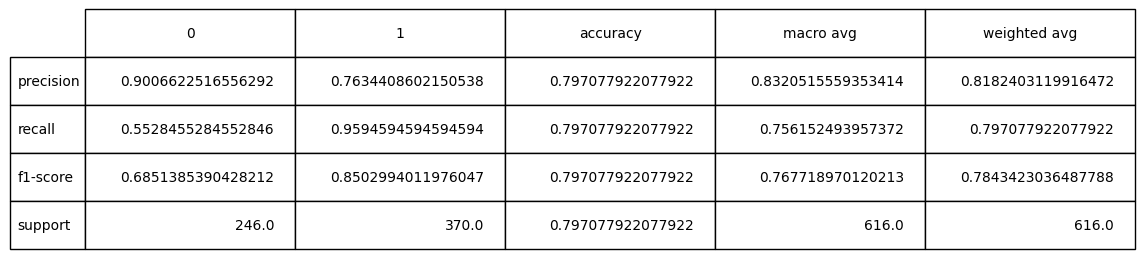

In [96]:
df = pd.DataFrame(classification_report(y_train, y_pred_train_lr, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

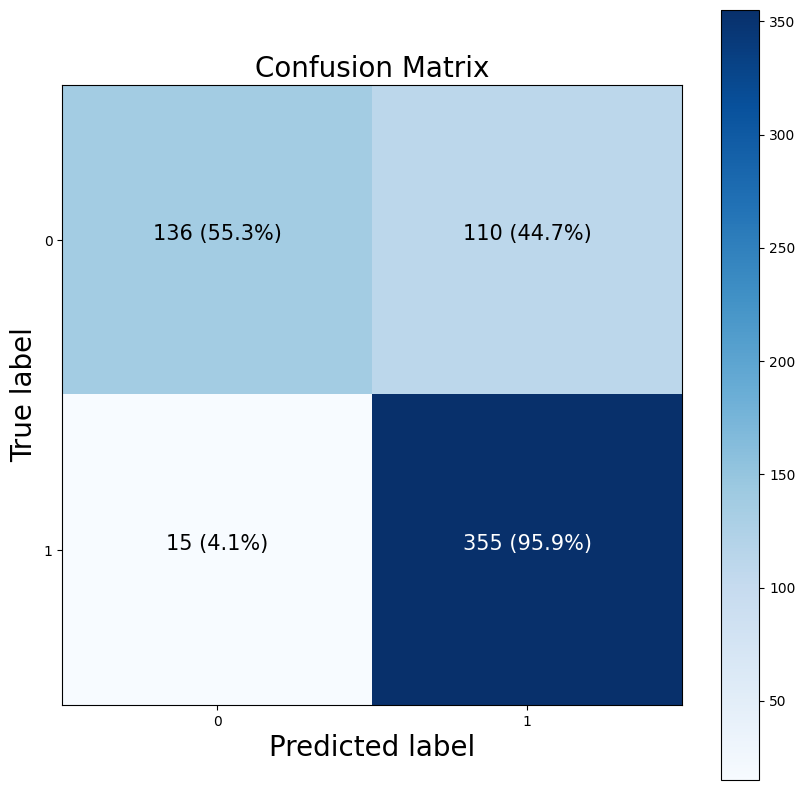

In [97]:
plot_confusion_matrix(y_train, y_pred_train_lr)

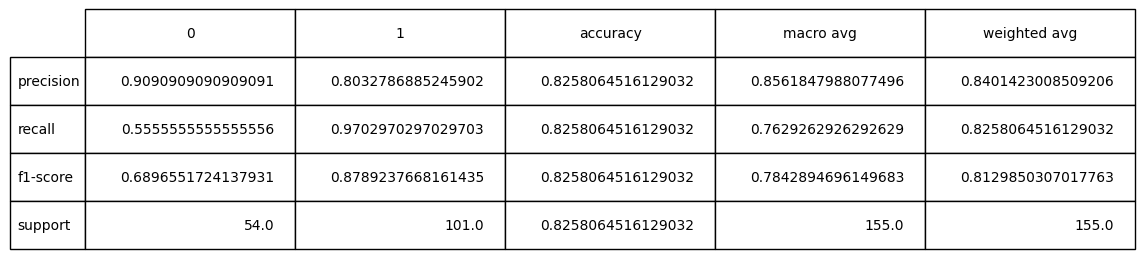

In [98]:
df = pd.DataFrame(classification_report(y_test, y_pred_test_lr, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

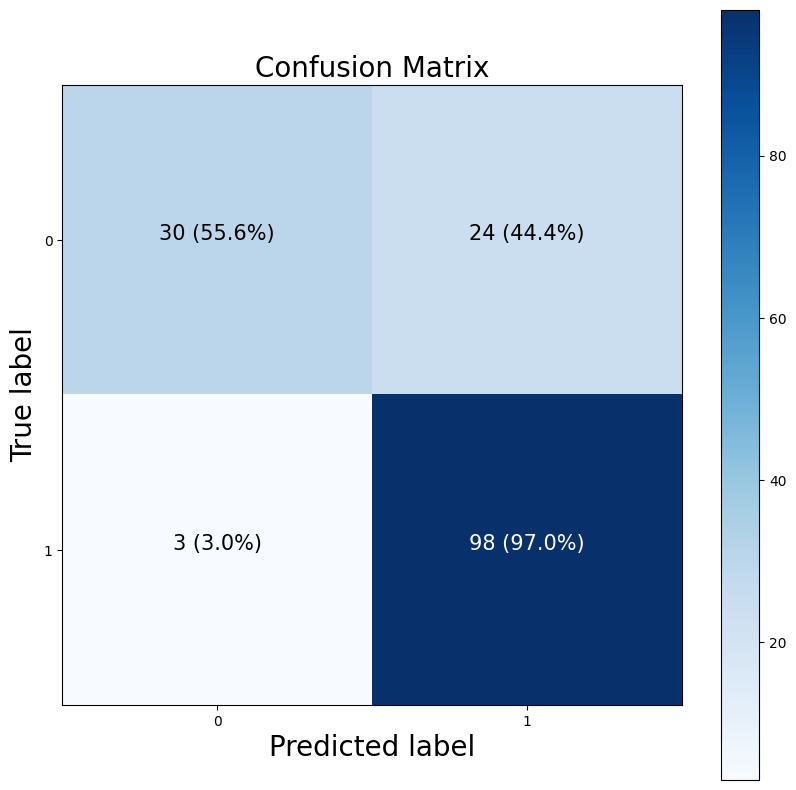

In [99]:
plot_confusion_matrix(y_test, y_pred_test_lr)

# Decision Tree Classifier:

In [100]:
params = {"criterion":("gini", "entropy"), 
          "splitter":("best", "random"), 
          "max_depth":(list(range(1, 20))), 
          "min_samples_split":[2, 3, 4], 
          "min_samples_leaf":list(range(1, 20))
          }

tree = DecisionTreeClassifier(random_state=406)

tree_cv = GridSearchCV(tree, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)

tree_cv.fit(X_train, y_train)


Fitting 5 folds for each of 4332 candidates, totalling 21660 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=406),
             n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19],
                         'min_samples_split': [2, 3, 4],
                         'splitter': ('best', 'random')},
             scoring='accuracy', verbose=1)

In [101]:
tree_tuned = DecisionTreeClassifier(**tree_cv.best_params_, random_state = 406)
tree_tuned.fit(X_train, y_train)
y_pred_train_tree = tree_tuned.predict(X_train) 
y_pred_test_tree = tree_tuned.predict(X_test)

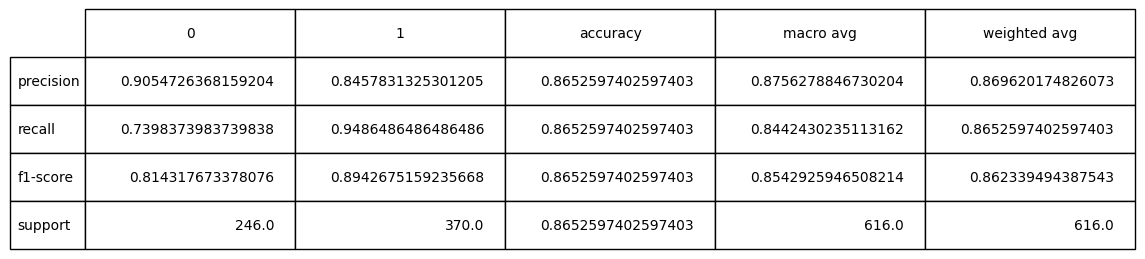

In [102]:
df = pd.DataFrame(classification_report(y_train, y_pred_train_tree, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

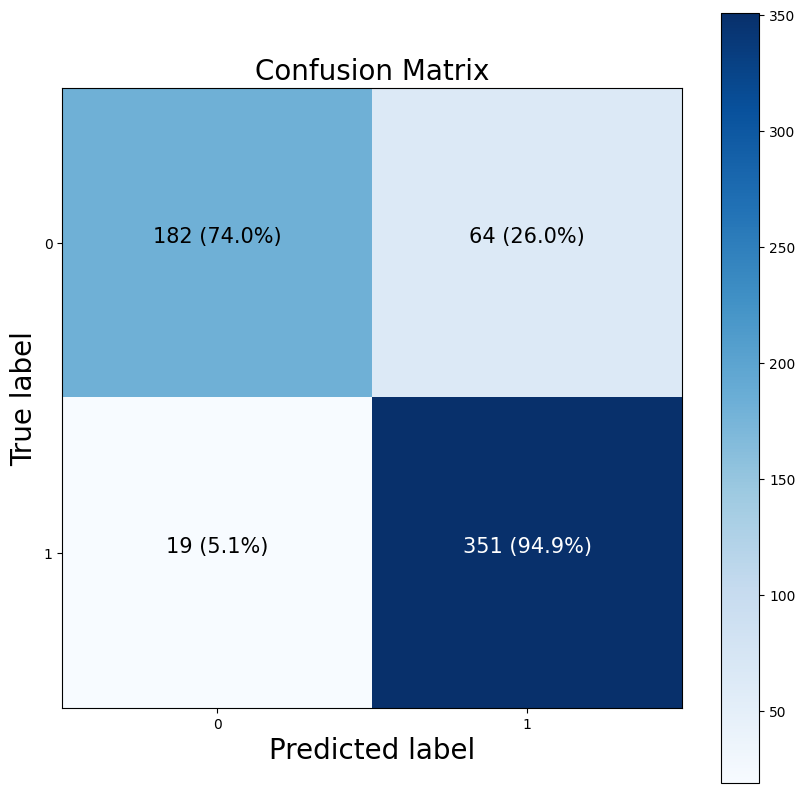

In [103]:
plot_confusion_matrix(y_train, y_pred_train_tree)

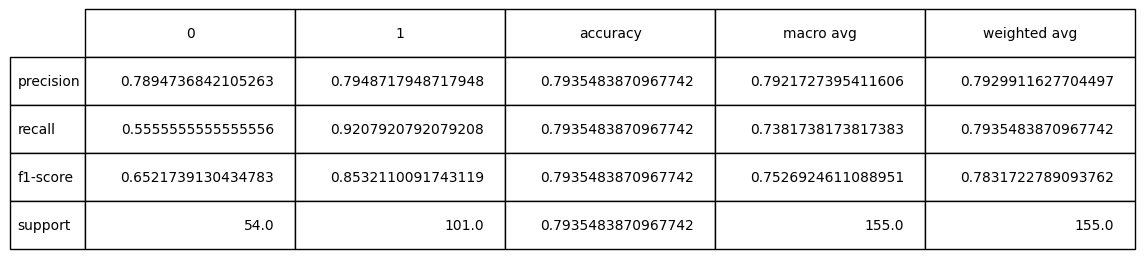

In [104]:
df = pd.DataFrame(classification_report(y_test, y_pred_test_tree, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

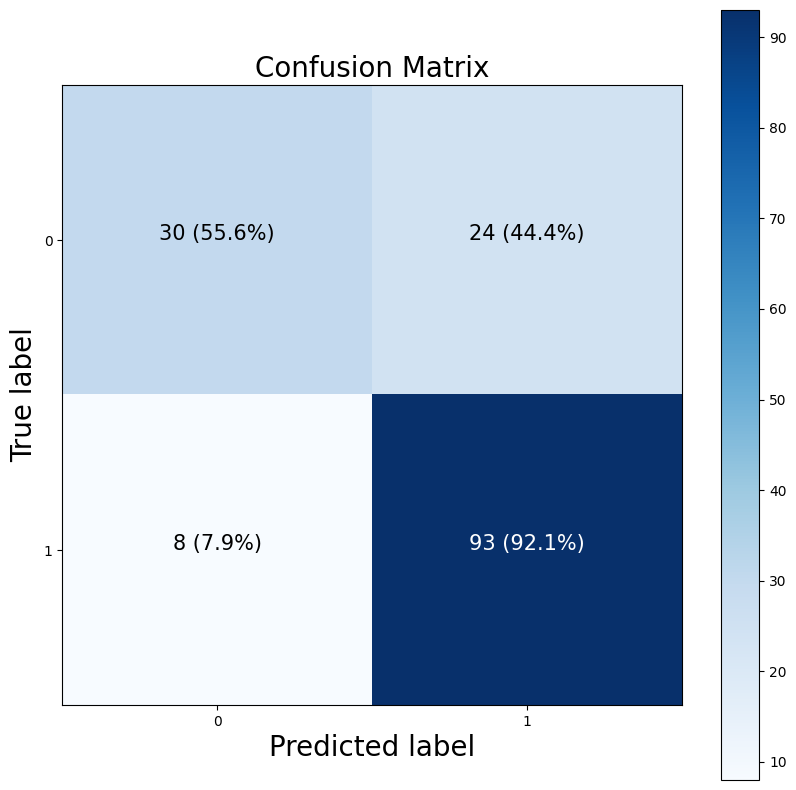

In [105]:
plot_confusion_matrix(y_test, y_pred_test_tree)

# Support Vector Machine:

In [106]:
svm = SVC(kernel='rbf', gamma=0.1, C=4.0, random_state= 113)

params = {"C":(0.1, 1, 10), 
          "gamma":(0.01, 0.1, 1), 
          "kernel":('linear', 'rbf')}               


svm_cv = GridSearchCV(svm, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)
svm_cv.fit(X_train, y_train)
    

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=SVC(C=4.0, gamma=0.1, random_state=113), n_jobs=-1,
             param_grid={'C': (0.1, 1, 10), 'gamma': (0.01, 0.1, 1),
                         'kernel': ('linear', 'rbf')},
             scoring='accuracy', verbose=1)

In [107]:
svm_tuned = SVC(**svm_cv.best_params_, random_state=113)
svm_tuned.fit(X_train, y_train)
y_pred_train_svm = svm_tuned.predict(X_train) 
y_pred_test_svm = svm_tuned.predict(X_test)

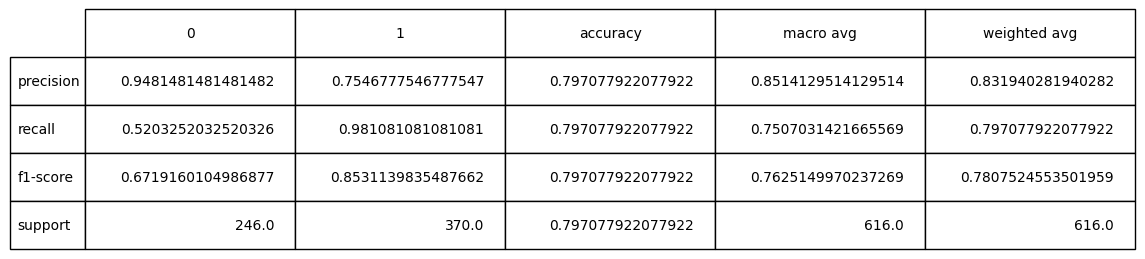

In [108]:
df = pd.DataFrame(classification_report(y_train, y_pred_train_svm, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

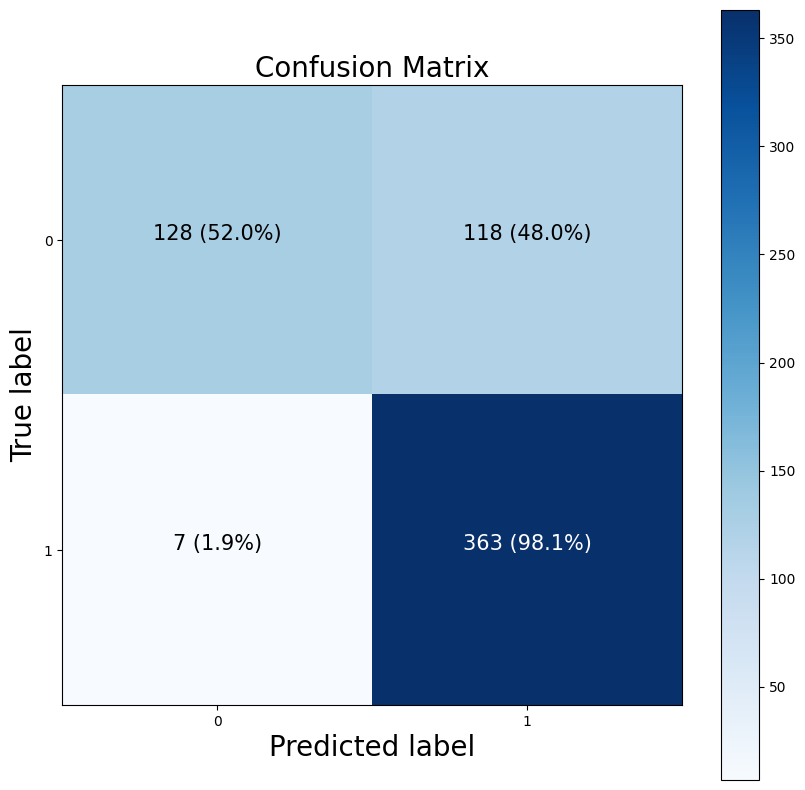

In [109]:
plot_confusion_matrix(y_train, y_pred_train_svm)

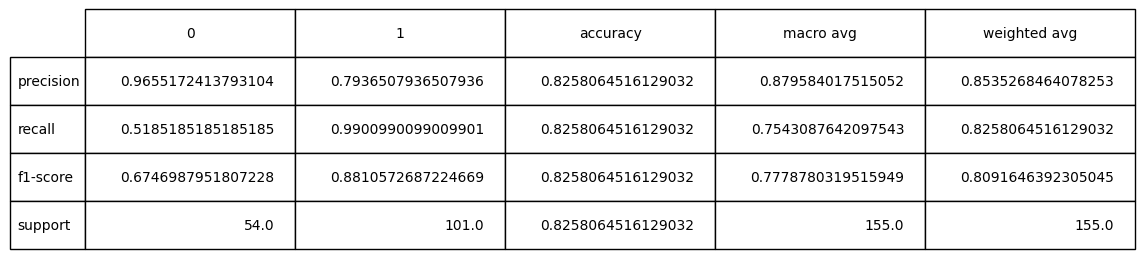

In [110]:
df = pd.DataFrame(classification_report(y_test, y_pred_test_svm, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

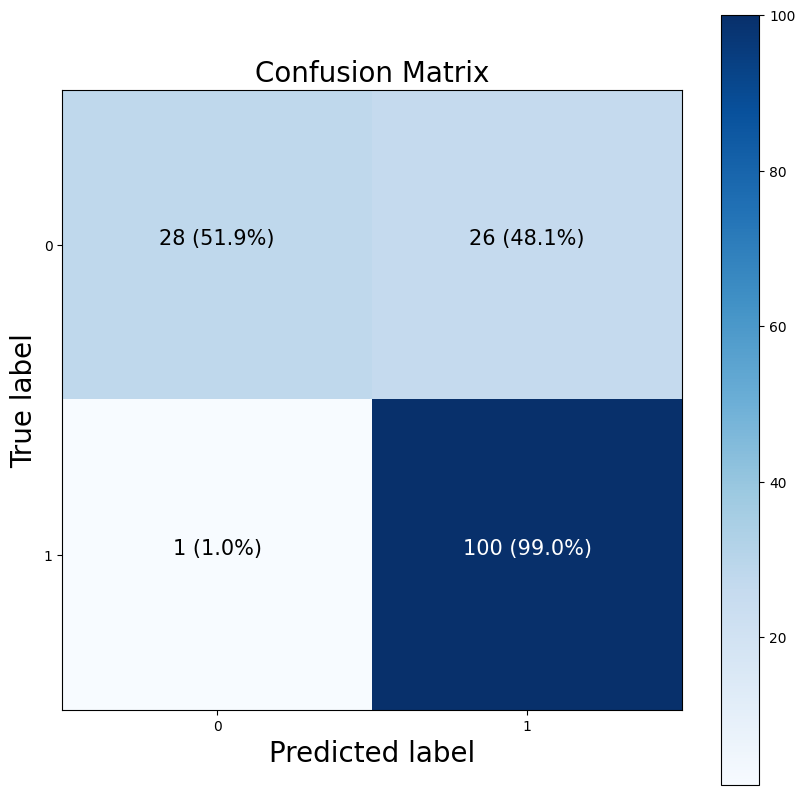

In [111]:
plot_confusion_matrix(y_test, y_pred_test_svm)

# XGBoost

In [112]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',n_jobs=-1,seed=42)

parameters = {
    'max_depth':(list(range(1, 20))),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
xgb_cv = GridSearchCV(xgb_model, parameters, scoring="roc_auc", n_jobs=-1, verbose=1, cv=10)
xgb_cv.fit(X_train, y_train)

Fitting 10 folds for each of 228 candidates, totalling 2280 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'n_estimators': range(60, 220, 40)},
             scoring='roc_auc', verbose=1)

In [113]:
y_pred_train_xgb = xgb_cv.predict(X_train)
y_pred_test_xgb = xgb_cv.predict(X_test)

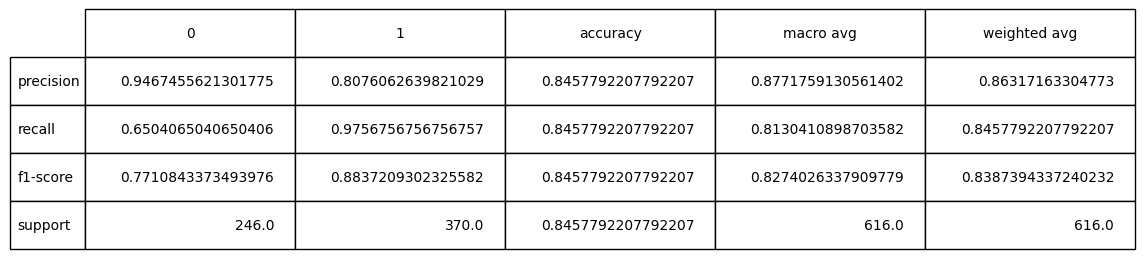

In [114]:
df = pd.DataFrame(classification_report(y_train, y_pred_train_xgb, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

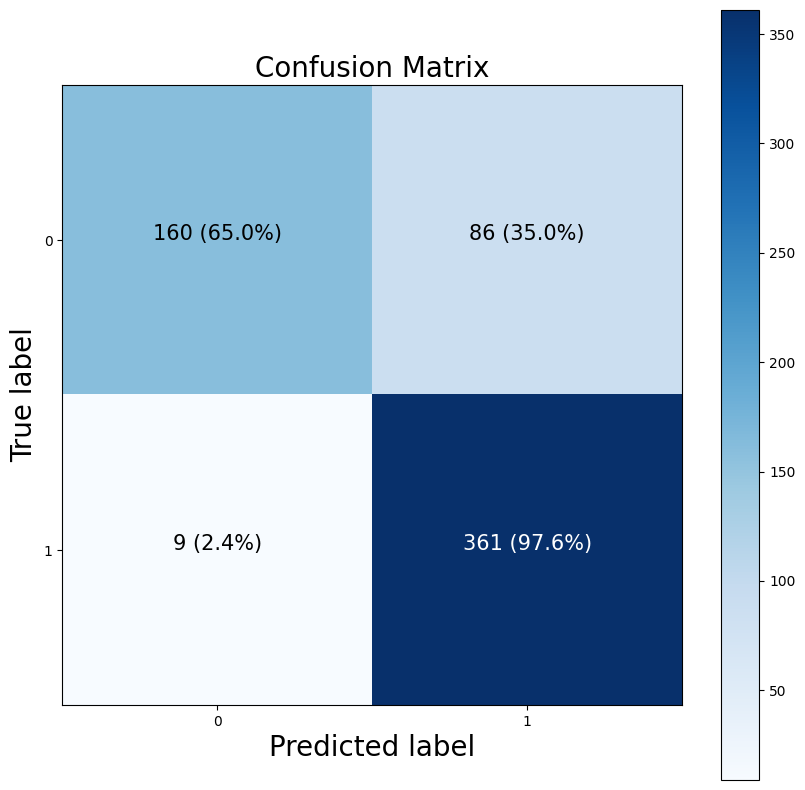

In [115]:
plot_confusion_matrix(y_train, y_pred_train_xgb)

/Users/mansibezbaruah/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mansibezbaruah/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mansibezbaruah/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

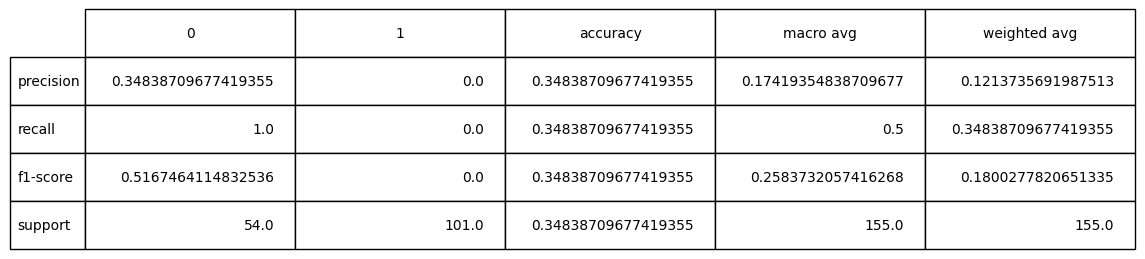

In [116]:
df = pd.DataFrame(classification_report(y_test, y_pred_test_xgb, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

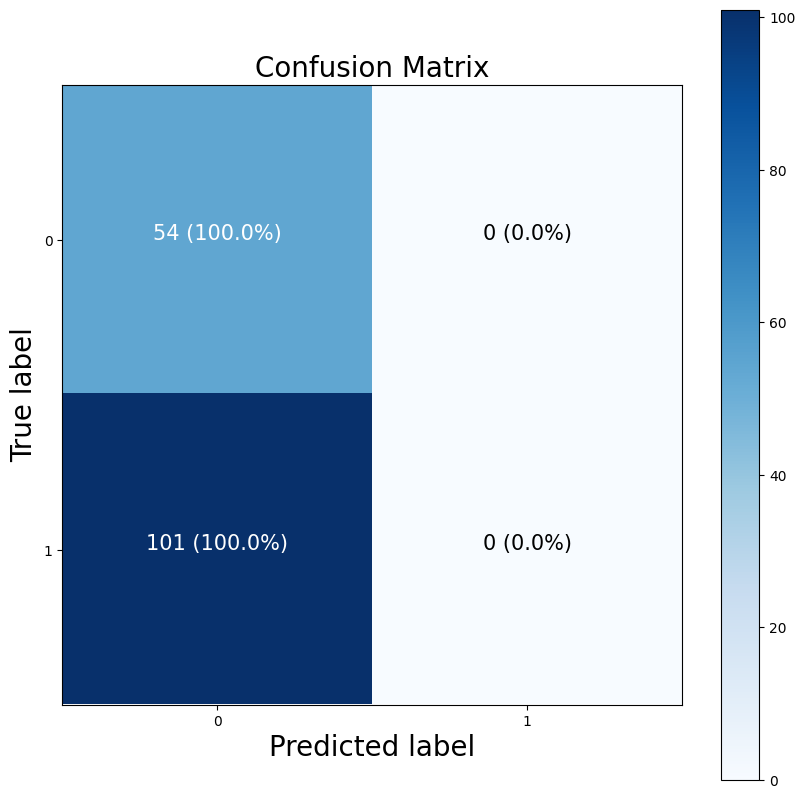

In [117]:
plot_confusion_matrix(y_test, y_pred_test_xgb)

# Deep Learning

In [118]:
input_shape = [X_train.shape[1]]

In [119]:
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=input_shape))
model.add(Dense(1, activation='sigmoid'))
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
20/20 [==============================] - 0s 504us/step - loss: 7.0815 - accuracy: 0.3994
Epoch 2/100
20/20 [==============================] - 0s 405us/step - loss: 4.7641 - accuracy: 0.3994
Epoch 3/100
20/20 [==============================] - 0s 449us/step - loss: 2.5963 - accuracy: 0.3994
Epoch 4/100
20/20 [==============================] - 0s 403us/step - loss: 0.8590 - accuracy: 0.5357
Epoch 5/100
20/20 [==============================] - 0s 440us/step - loss: 0.6273 - accuracy: 0.6623
Epoch 6/100
20/20 [==============================] - 0s 380us/step - loss: 0.5857 - accuracy: 0.7273
Epoch 7/100
20/20 [==============================] - 0s 438us/step - loss: 0.5663 - accuracy: 0.7256
Epoch 8/100
20/20 [==============================] - 0s 810us/step - loss: 0.5568 - accuracy: 0.7581
Epoch 9/100
20/20 [==============================] - 0s 446us/step - loss: 0.5494 - accuracy: 0.7679
Epoch 10/100
20/20 [==============================] - 0s 393us/step - loss: 0.5431 - accura

In [120]:
loss_and_metrics = model.evaluate(X_test, y_test)
print(loss_and_metrics)
print('Loss = ',loss_and_metrics[0])
print('Accuracy = ',loss_and_metrics[1])

5/5 [==============================] - 0s 687us/step - loss: 0.4230 - accuracy: 0.8194
[0.4229748547077179, 0.8193548321723938]
Loss =  0.4229748547077179
Accuracy =  0.8193548321723938


In [121]:
y_pred_train_DL = model.predict(X_train) 
y_pred_test_DL = model.predict(X_test)

5/5 [==============================] - 0s 481us/step


In [122]:
actual_train = np.array(y_train)
predicted_train = tf.squeeze(y_pred_train_DL)
predicted_train = np.array([1 if x >= 0.5 else 0 for x in predicted_train])

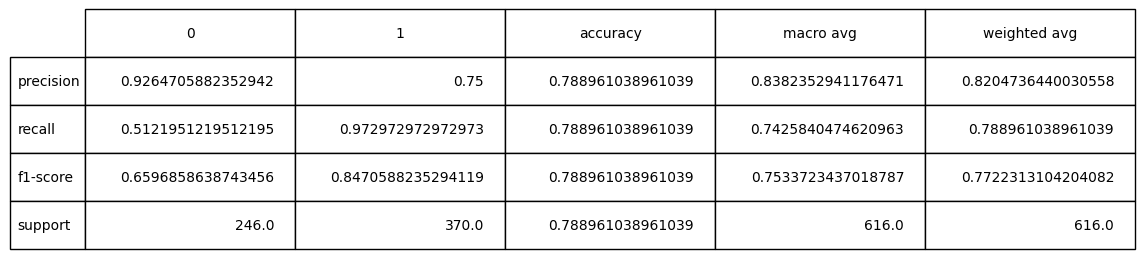

In [123]:
df = pd.DataFrame(classification_report(actual_train, predicted_train, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

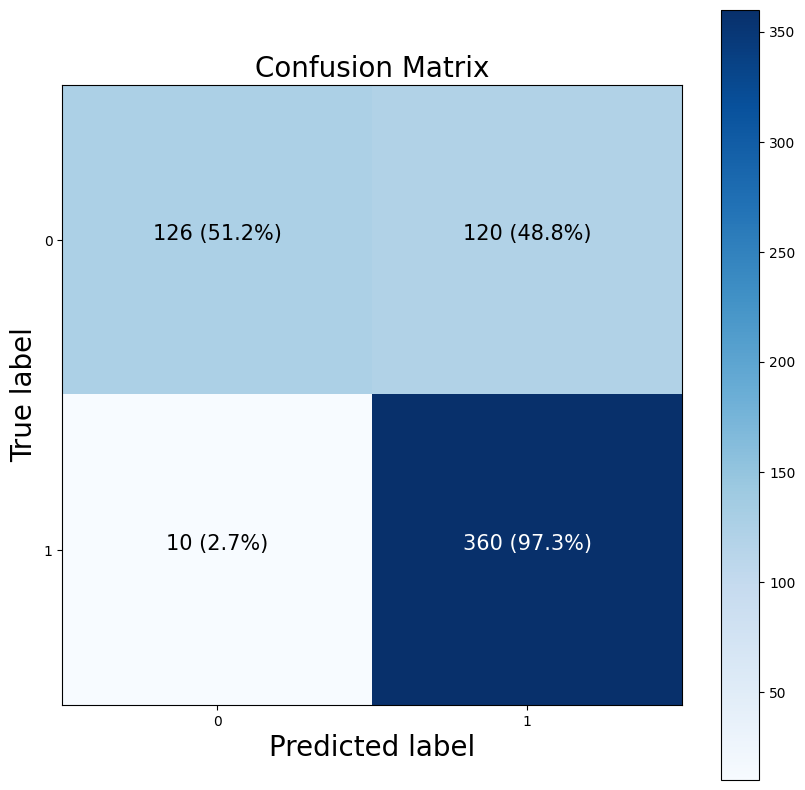

In [124]:
plot_confusion_matrix(actual_train,predicted_train)

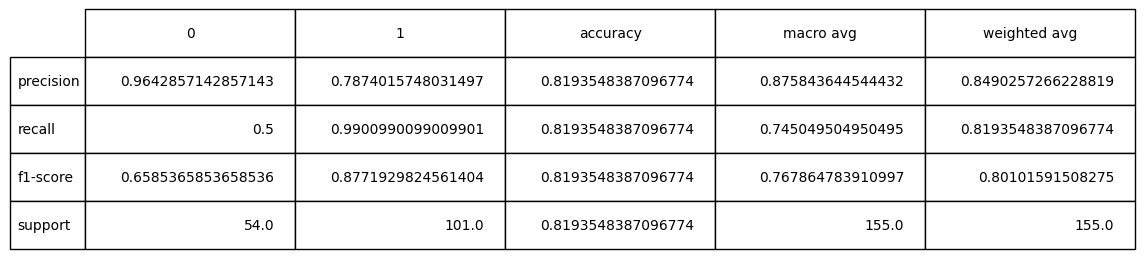

In [125]:
actual_test = np.array(y_test)
predicted_test = tf.squeeze(y_pred_test_DL)
predicted_test = np.array([1 if x >= 0.5 else 0 for x in predicted_test])


df = pd.DataFrame(classification_report(actual_test, predicted_test, output_dict=True))
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0, 0, 1, 1], fontsize=14)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.6)

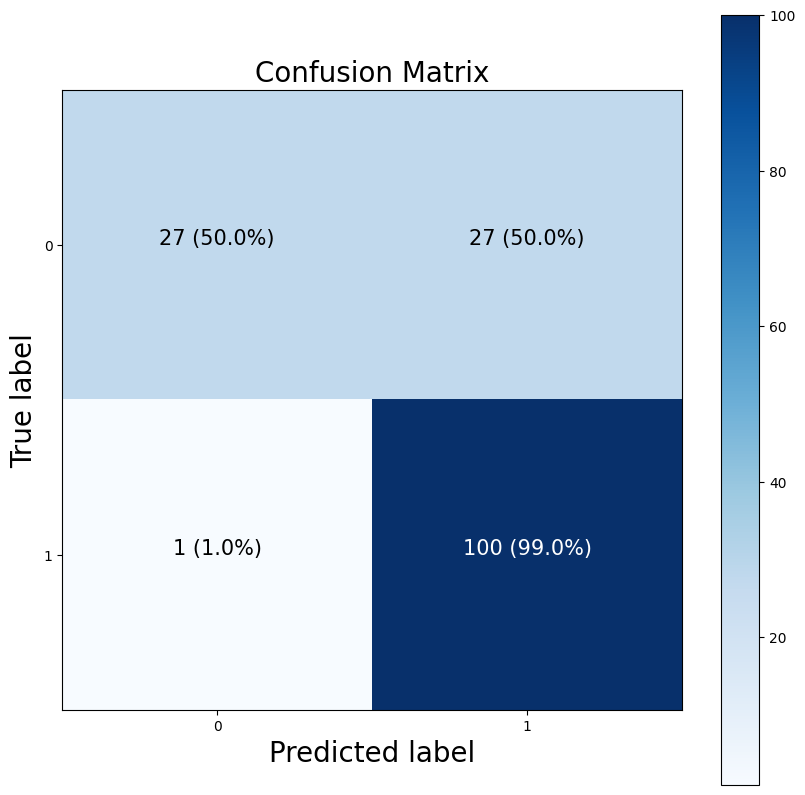

In [126]:
plot_confusion_matrix(actual_test,predicted_test)